In [1]:
%%capture --no-stderr
%pip install -U  langgraph tavily-python wikipedia langchain_openai langchain_community langgraph_sdk

In [2]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

### created my own graph example with 5 nodes, and 3 nodes in one step

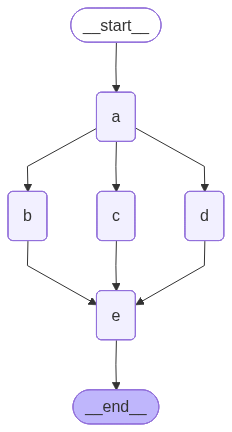

In [3]:
from IPython.display import Image, display

from typing import Any
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END

class State(TypedDict):
    # The operator.add reducer fn makes this append-only
    state: str

class ReturnNodeValue:
    def __init__(self, node_secret: str):
        self._value = node_secret

    def __call__(self, state: State) -> Any:
        print(f"Adding {self._value} to {state['state']}")
        return {"state": [self._value]}

builder = StateGraph(State)

# Initialize each node with node_secret 
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))
builder.add_node("e", ReturnNodeValue("I'm E"))

# Flow
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("a", "d")
builder.add_edge("b", "e")
builder.add_edge("c", "e")
builder.add_edge("d", "e")
builder.add_edge("e", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

#### demonstrated the error when run normally

In [ ]:
from langgraph.errors import InvalidUpdateError
try:
    graph.invoke({"state": []})
except InvalidUpdateError as e:
    print(f"An error occurred: {e}")

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm A"]
Adding I'm D to ["I'm A"]
An error occurred: At key 'state': Can receive only one value per step. Use an Annotated key to handle multiple values.
For troubleshooting, visit: https://docs.langchain.com/oss/python/langgraph/errors/INVALID_CONCURRENT_GRAPH_UPDATE


Failed to multipart ingest runs: langsmith.utils.LangSmithRateLimitError: Rate limit exceeded for https://api.smith.langchain.com/runs/multipart. HTTPError('429 Client Error: Too Many Requests for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Too many requests: tenant exceeded usage limits: Monthly unique traces usage limit exceeded"}\n')trace=5ebb43bc-374e-4e61-b3c7-fc71b109a208,id=5ebb43bc-374e-4e61-b3c7-fc71b109a208; trace=5ebb43bc-374e-4e61-b3c7-fc71b109a208,id=80c2b542-6248-42f1-92b1-40fcdefe4042; trace=5ebb43bc-374e-4e61-b3c7-fc71b109a208,id=d82f2163-0885-4b60-897f-7dadf2d00b86; trace=5ebb43bc-374e-4e61-b3c7-fc71b109a208,id=108dc644-eb63-494a-81f9-15f60efd4062; trace=5ebb43bc-374e-4e61-b3c7-fc71b109a208,id=a6433c9a-cec5-431d-8509-fb8c94c78982; trace=4fb6044c-29d0-416d-aed5-94f14698420d,id=4fb6044c-29d0-416d-aed5-94f14698420d; trace=4fb6044c-29d0-416d-aed5-94f14698420d,id=d3c85879-a341-4f84-b51b-cdb5c0de396d; trace=4fb6044c-29d0-416d-aed5-94f14698420d,id=399a93e

### fixed the error by adding a reducer

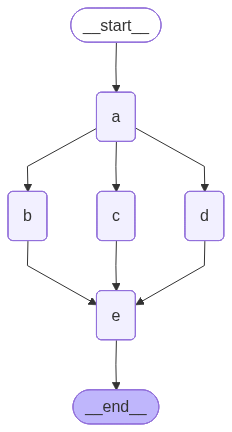

In [5]:
import operator
from typing import Annotated

class State(TypedDict):
    # The operator.add reducer fn makes this append-only
    state: Annotated[list, operator.add]

# Add nodes
builder = StateGraph(State)


# Initialize each node with node_secret 
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))
builder.add_node("e", ReturnNodeValue("I'm E"))

# Flow
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("a", "d")
builder.add_edge("b", "e")
builder.add_edge("c", "e")
builder.add_edge("d", "e")
builder.add_edge("e", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [6]:
graph.invoke({"state": []})

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm A"]
Adding I'm D to ["I'm A"]
Adding I'm E to ["I'm A", "I'm B", "I'm C", "I'm D"]


{'state': ["I'm A", "I'm B", "I'm C", "I'm D", "I'm E"]}

## multiple node in 1 step , along with multiple nodes in branches as well

### made my own complex example, with 5 nodes 3, and 2 nodes in a branch respectively

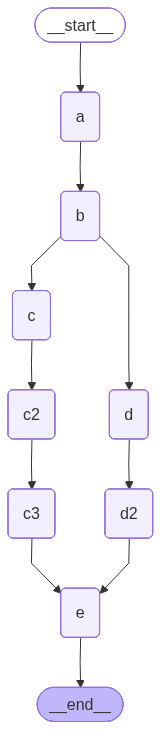

{'animals': ['zebra', 'cat', 'dog', 'wolf', 'lion', 'tiger', 'giraffe', 'elephant']}


In [7]:
from typing import Annotated
from typing_extensions import TypedDict
import operator
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

class State(TypedDict):
    animals: Annotated[list, operator.add]

def node_a(state: State): return {"animals": ["zebra"]}
def node_b(state: State): return {"animals": ["cat"]}
def node_c(state: State): return {"animals": ["dog"]}
def node_c2(state: State): return {"animals": ["lion"]}
def node_c3(state: State): return {"animals": ["giraffe"]}
def node_d(state: State): return {"animals": ["wolf"]}
def node_d2(state: State): return {"animals": ["tiger"]}
def node_e(state: State): return {"animals": ["elephant"]}

builder = StateGraph(State)
builder.add_node("a", node_a)
builder.add_node("b", node_b)
builder.add_node("c", node_c)
builder.add_node("c2", node_c2)
builder.add_node("c3", node_c3)
builder.add_node("d", node_d)
builder.add_node("d2", node_d2)
builder.add_node("e", node_e)

builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("b", "c")
builder.add_edge("c", "c2")
builder.add_edge("c2", "c3")
builder.add_edge("b", "d")
builder.add_edge("d", "d2")
builder.add_edge(["c3", "d2"], "e")
builder.add_edge("e", END)

graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

print(graph.invoke({"animals": []}))


### without custom reducer output:

In [8]:
graph.invoke({"animals": []})

{'animals': ['zebra',
  'cat',
  'dog',
  'wolf',
  'lion',
  'tiger',
  'giraffe',
  'elephant']}

### same graph but with custom reducer, that sorts the output alphabetically

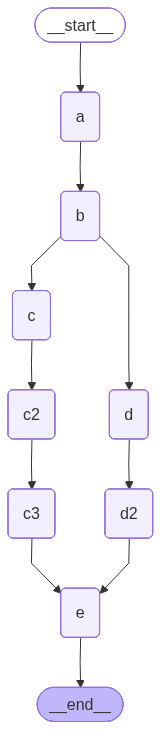

Final sorted animal list in state: ['cat', 'dog', 'elephant', 'giraffe', 'lion', 'tiger', 'wolf', 'zebra']


In [9]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END

# Custom reducer: sorts and deduplicates animal names
def animal_sorted_reducer(left, right):
    if not isinstance(left, list): left = [left]
    if not isinstance(right, list): right = [right]
    return sorted(set(left + right))

class State(TypedDict):
    animals: Annotated[list, animal_sorted_reducer]

# Each node returns ONE distinct animal
def node_a(state: State): return {"animals": ["zebra"]}
def node_b(state: State): return {"animals": ["cat"]}
def node_c1(state: State): return {"animals": ["dog"]}
def node_c2(state: State): return {"animals": ["lion"]}
def node_c3(state: State): return {"animals": ["giraffe"]}
def node_d1(state: State): return {"animals": ["wolf"]}
def node_d2(state: State): return {"animals": ["tiger"]}
def node_e(state: State): return {"animals": ["elephant"]}

# Build graph matching previous structure
builder = StateGraph(State)
builder.add_node("a", node_a)
builder.add_node("b", node_b)
builder.add_node("c", node_c1)
builder.add_node("c2", node_c2)
builder.add_node("c3", node_c3)
builder.add_node("d", node_d1)
builder.add_node("d2", node_d2)
builder.add_node("e", node_e)

builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("b", "c")
builder.add_edge("c", "c2")
builder.add_edge("c2", "c3")
builder.add_edge("b", "d")
builder.add_edge("d", "d2")
builder.add_edge(["c3", "d2"], "e")



builder.add_edge("e", END)

graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))
result = graph.invoke({"animals": []})
print("Final sorted animal list in state:", result["animals"])


with custom reducer output

## Created my ownn pokedex llm with a multi node setup :

In [10]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o", temperature=0) 

In [11]:
class State(TypedDict):
    question: str
    answer: str
    context: Annotated[list, operator.add]

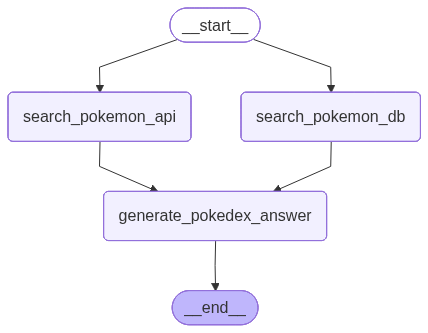

In [12]:
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_community.tools import TavilySearchResults

def search_pokemon_db(state):
    """ Retrieve docs from a Pokemon database website """

    # Mock of PokemonDB search results (replace with actual API/tool calls if available)
    query = state['question']
    search_docs = [
        {"url": f"https://pokemondb.net/pokedex/{query.lower()}",
         "content": f"Details about {query} from PokemonDB."},
        {"url": f"https://pokemondb.net/pokedex/{query.lower()}/evolution",
         "content": f"Evolution info and stats for {query}."}
    ]

    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<PokeDB href="{doc["url"]}">\n{doc["content"]}\n</PokeDB>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}


def search_pokemon_api(state):
    """ Retrieve docs from a Pokemon API website """

    # Mock Pokemon API search results (replace with actual API/tool calls if available)
    query = state['question']
    search_docs = [
        {"url": f"https://pokeapi.co/api/v2/pokemon/{query.lower()}",
         "content": f"API data and stats for {query}."},
        {"url": f"https://pokecharms.com/pokedex/pokemon/{query.lower()}",
         "content": f"Additional info and user guides for {query}."}
    ]

    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<PokeAPI href="{doc["url"]}">\n{doc["content"]}\n</PokeAPI>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}


def generate_pokedex_answer(state):
    """ Node to answer a question using the combined pokemon info """

    context = state.get("context", [])
    question = state.get("question", "")

    answer_template = """Answer the question '{question}' using the following Pokémon info: {context}"""
    answer_instructions = answer_template.format(question=question, context="\n".join(context))

    answer = llm.invoke([
        SystemMessage(content=answer_instructions),
        HumanMessage(content="Answer the Pokémon question.")
    ])

    return {"answer": answer}

# Add nodes
builder = StateGraph(State)

# Initialize each node with node_secret 
builder.add_node("search_pokemon_db", search_pokemon_db)
builder.add_node("search_pokemon_api", search_pokemon_api)
builder.add_node("generate_pokedex_answer", generate_pokedex_answer)

# Flow
builder.add_edge(START, "search_pokemon_db")
builder.add_edge(START, "search_pokemon_api")
builder.add_edge("search_pokemon_db", "generate_pokedex_answer")
builder.add_edge("search_pokemon_api", "generate_pokedex_answer")
builder.add_edge("generate_pokedex_answer", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))


#### tested it out with multiple examples :

In [13]:
result = graph.invoke({"question": "What are the base stats of Ditto?"})
result['answer'].content

'The base stats of Ditto are as follows:\n\n- HP: 48\n- Attack: 48\n- Defense: 48\n- Special Attack: 48\n- Special Defense: 48\n- Speed: 48\n\nDitto has uniform base stats across all categories.'

In [14]:
result = graph.invoke({"question": "WHO WOULD WIN BW A MEWTWO AND A BULBASAUR, is there even 0.0001% chance that bulbasaur might win if yes then what is it, keep it max 20 words?"})
result['answer'].content

'Mewtwo would win against Bulbasaur. Bulbasaur might win if Mewtwo is severely weakened or incapacitated, but chances are extremely low.'

## tested out the llm through the langgraph api

### LANGGRAPH API:

#### I created the pokedex.py file to get access to this code through the langgraph api :

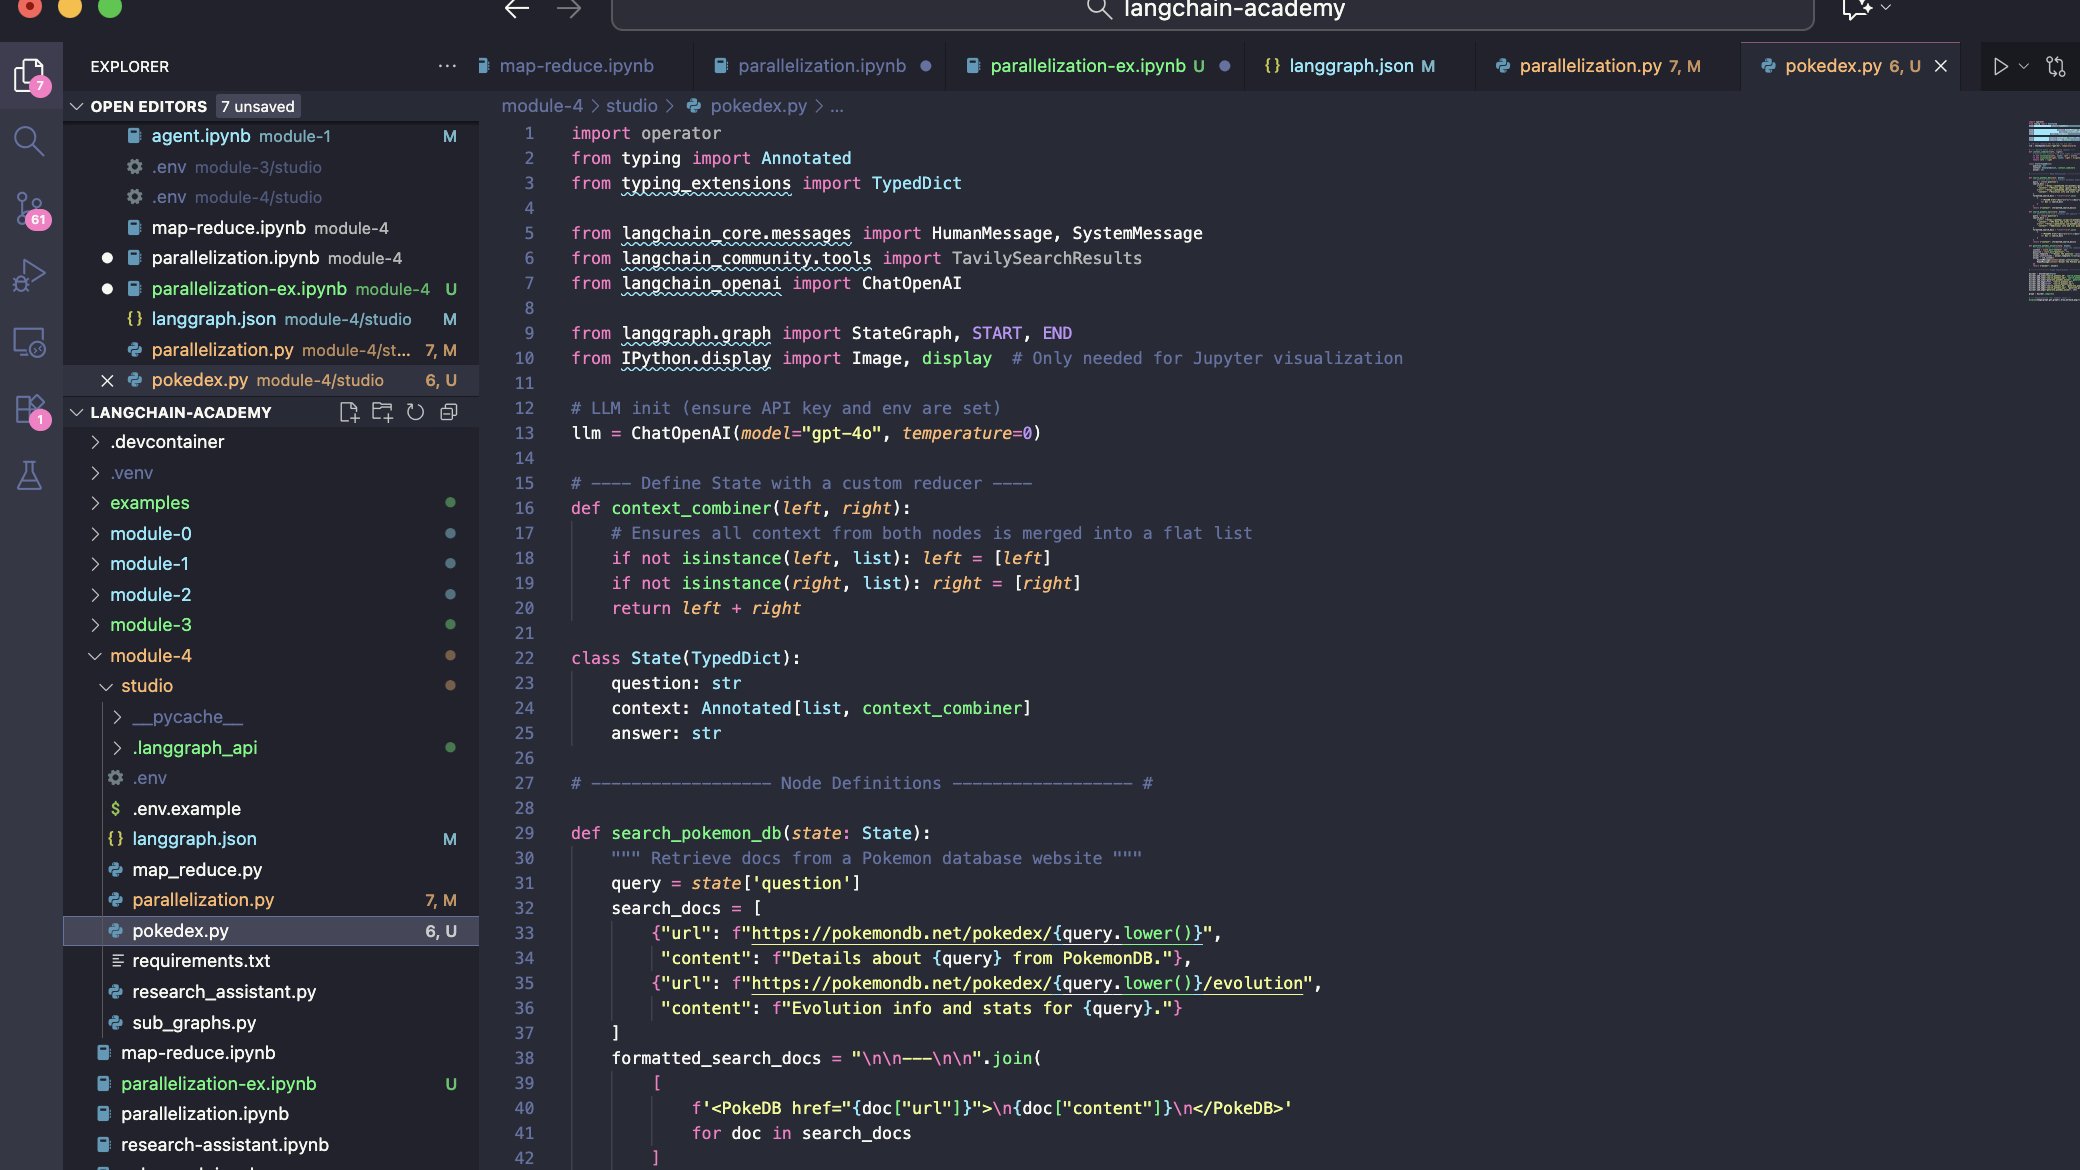

#### added pokedex.py to langgraph.json :

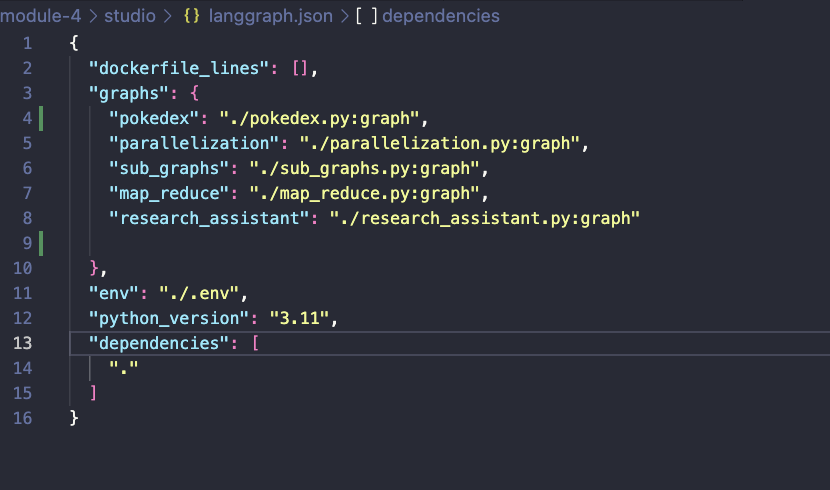

In [15]:
from langgraph_sdk import get_client
client = get_client(url="http://127.0.0.1:2024")

#### tested it out with multiple examples :

In [16]:
thread = await client.threads.create()
input_question = {"question": "Tell me about Charizard's abilities and evolution"}
async for event in client.runs.stream(thread["thread_id"], 
                                      assistant_id="pokedex", 
                                      input=input_question, 
                                      stream_mode="values"):
    # Check if answer has been added to state  
    if event.data is not None:
        answer = event.data.get('answer', None)
        if answer:
            print(answer['content'])

Charizard is a Fire/Flying-type Pokémon known for its powerful abilities and evolutionary line. 

**Abilities:**
1. **Blaze**: This is Charizard's primary ability. It boosts the power of Fire-type moves by 50% when Charizard's HP is below a third of its maximum.
2. **Solar Power (Hidden Ability)**: This ability increases Charizard's Special Attack by 50% in sunny weather, but it also causes Charizard to lose some HP each turn.

**Evolution:**
Charizard is the final form in its evolutionary line. It evolves from Charmeleon starting at level 36, which in turn evolves from Charmander starting at level 16. Charmander is the first stage of this evolutionary line, known for its small, lizard-like appearance and fiery tail. As it evolves, it gains more power and eventually becomes the formidable Charizard, capable of flight and powerful fire-based attacks.

Additionally, Charizard has two Mega Evolutions: Mega Charizard X and Mega Charizard Y, which can be accessed using the respective Mega S

In [17]:
thread = await client.threads.create()
input_question = {"question": "list 5 pokemon which use sleep powder move effectively"}
async for event in client.runs.stream(thread["thread_id"], 
                                      assistant_id="pokedex", 
                                      input=input_question, 
                                      stream_mode="values"):
    # Check if answer has been added to state  
    if event.data is not None:
        answer = event.data.get('answer', None)
        if answer:
            print(answer['content'])

Here are five Pokémon that use the move Sleep Powder effectively:

1. **Venusaur** - With its high Special Attack and bulk, Venusaur can effectively use Sleep Powder to incapacitate opponents and set up for powerful attacks or healing.

2. **Butterfree** - Known for its Compound Eyes ability, which increases accuracy, Butterfree can use Sleep Powder with a higher chance of success, making it a reliable choice for putting opponents to sleep.

3. **Vileplume** - This Pokémon has good defensive stats and can use Sleep Powder to disrupt opponents, allowing it to set up with moves like Giga Drain or Sludge Bomb.

4. **Tangrowth** - With its high defensive stats, Tangrowth can take hits while using Sleep Powder to disable opponents, giving it time to recover or set up with other moves.

5. **Roserade** - Known for its high Special Attack, Roserade can use Sleep Powder to incapacitate foes and then follow up with powerful moves like Leaf Storm or Sludge Bomb.

These Pokémon leverage Sleep Pow

In [18]:
thread = await client.threads.create()
input_question = {"question": "list 5 cutest pokemon that can learn fly move"}
async for event in client.runs.stream(thread["thread_id"], 
                                      assistant_id="pokedex", 
                                      input=input_question, 
                                      stream_mode="values"):
    # Check if answer has been added to state  
    if event.data is not None:
        answer = event.data.get('answer', None)
        if answer:
            print(answer['content'])

Here are 5 of the cutest Pokémon that can learn the Fly move:

1. **Togekiss** - Known for its adorable appearance and friendly nature, Togekiss is a Fairy/Flying-type Pokémon that can learn Fly.

2. **Emolga** - This Electric/Flying-type Pokémon resembles a flying squirrel and is known for its cuteness and ability to learn Fly.

3. **Pikipek** - A small, woodpecker-like Pokémon that evolves into the majestic Toucannon, Pikipek is a Normal/Flying-type that can learn Fly.

4. **Rowlet** - The Grass/Flying-type starter Pokémon from the Alola region, Rowlet is both cute and capable of learning Fly.

5. **Swablu** - With its cloud-like wings and sweet demeanor, Swablu is a Normal/Flying-type Pokémon that can learn Fly.

These Pokémon are not only cute but also versatile in battles with their ability to use the Fly move.


### LANGGRAPH STUDIO

#### I explored my pokedex graph on the langgraph studio and played around with it, I could see in detail how the nodes were accessed and how the result was generated 

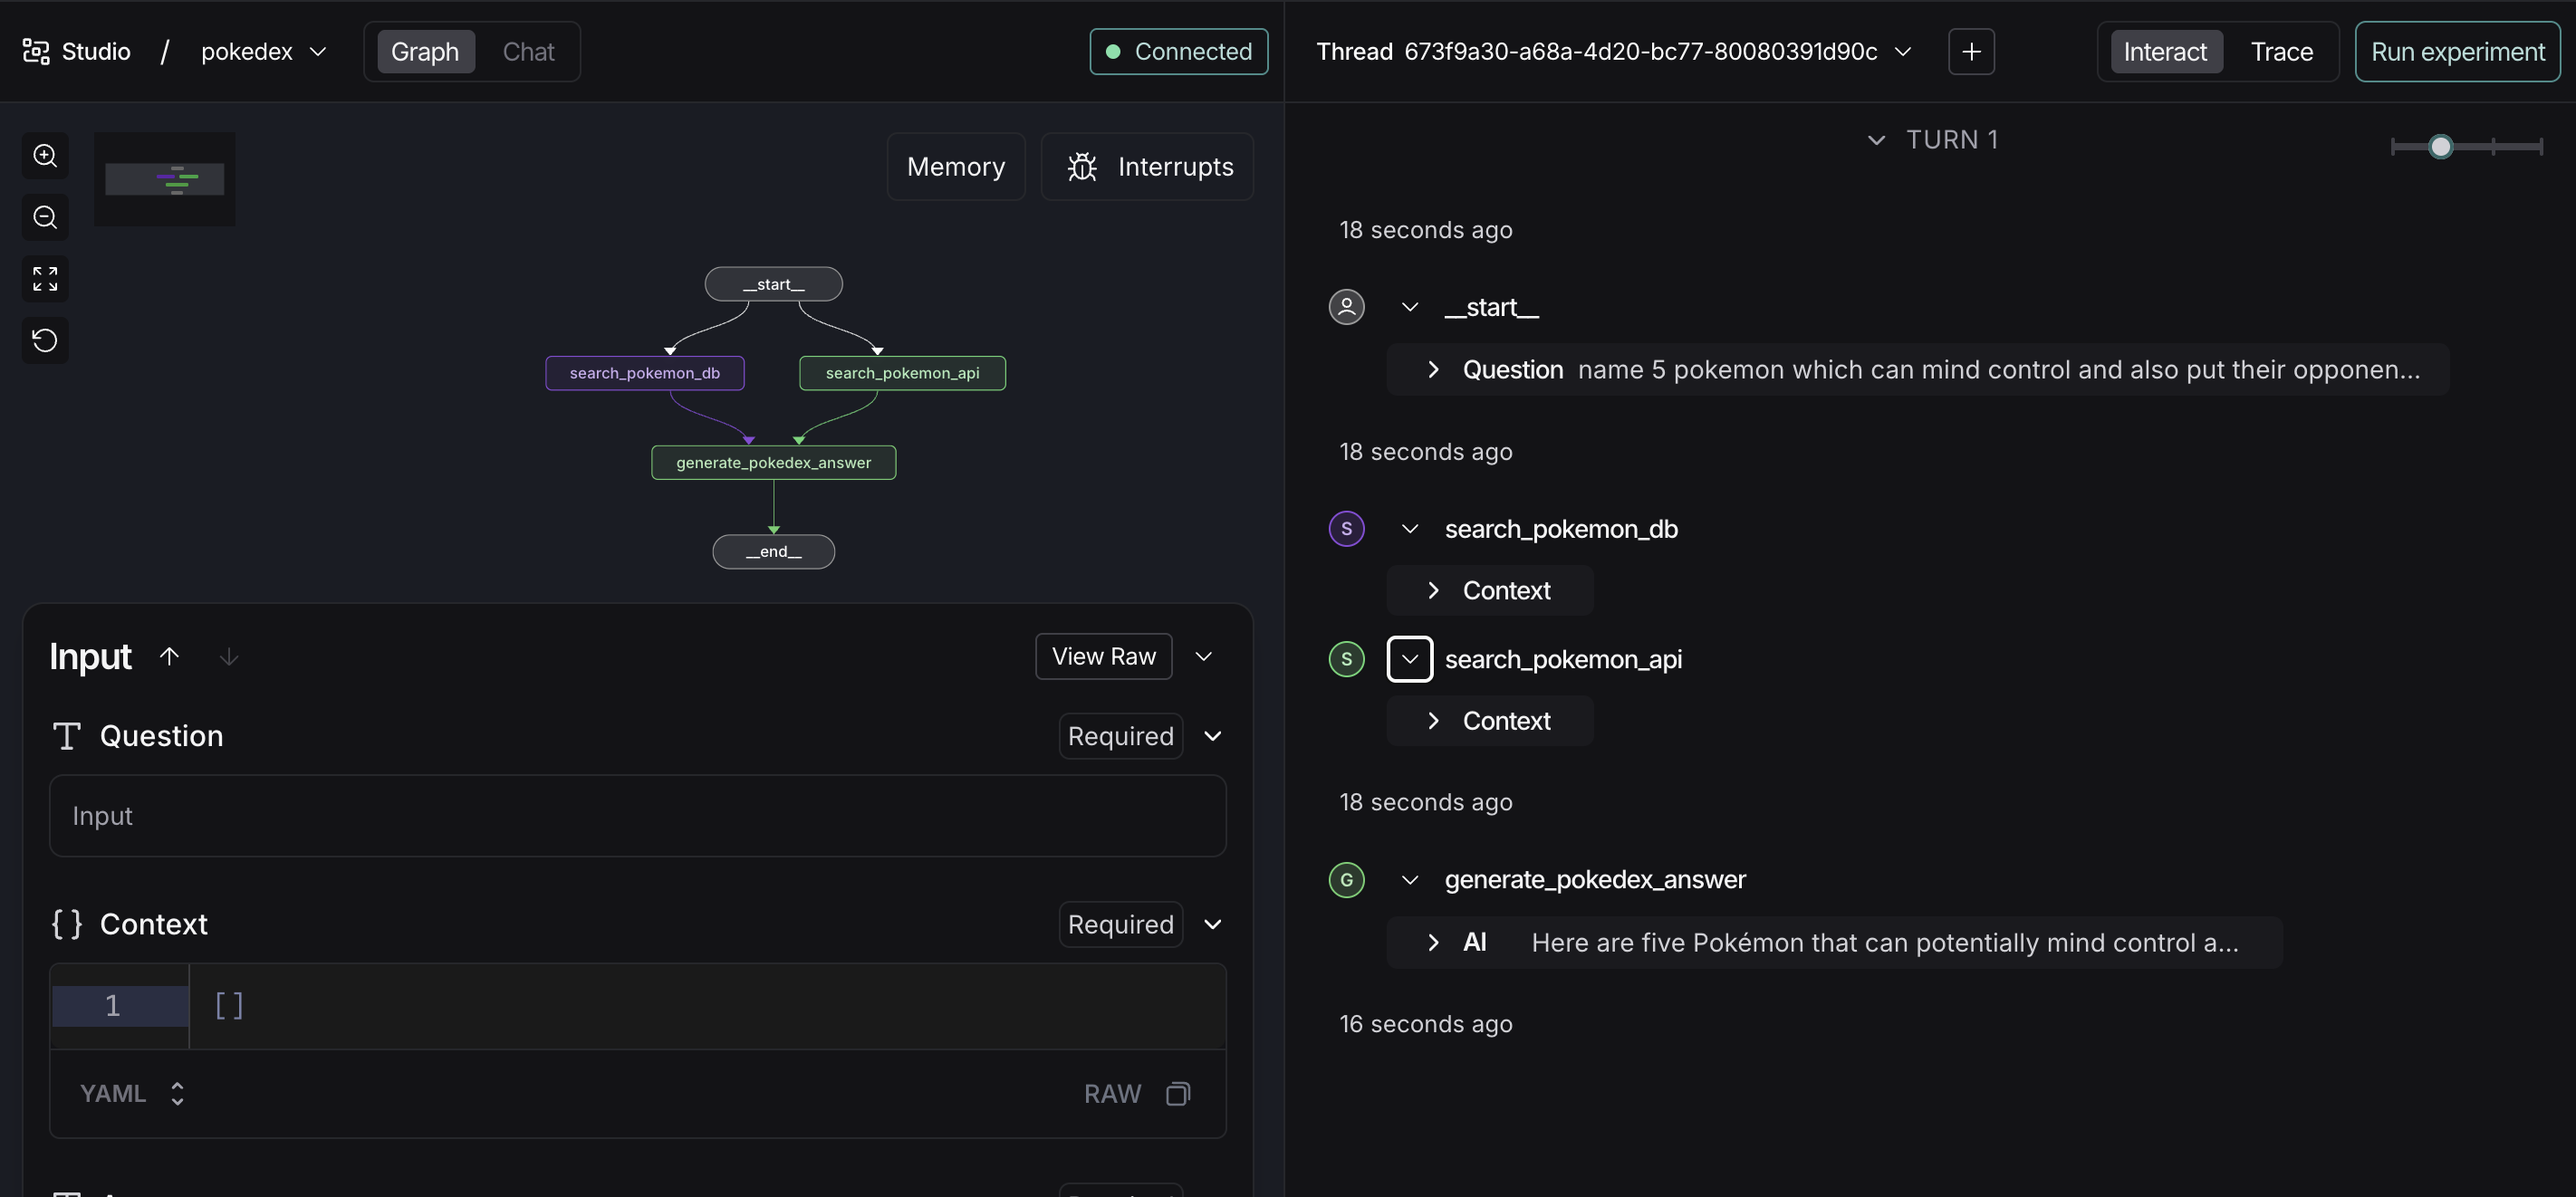

### stepwise-execution of the pokedex graph :

first search function

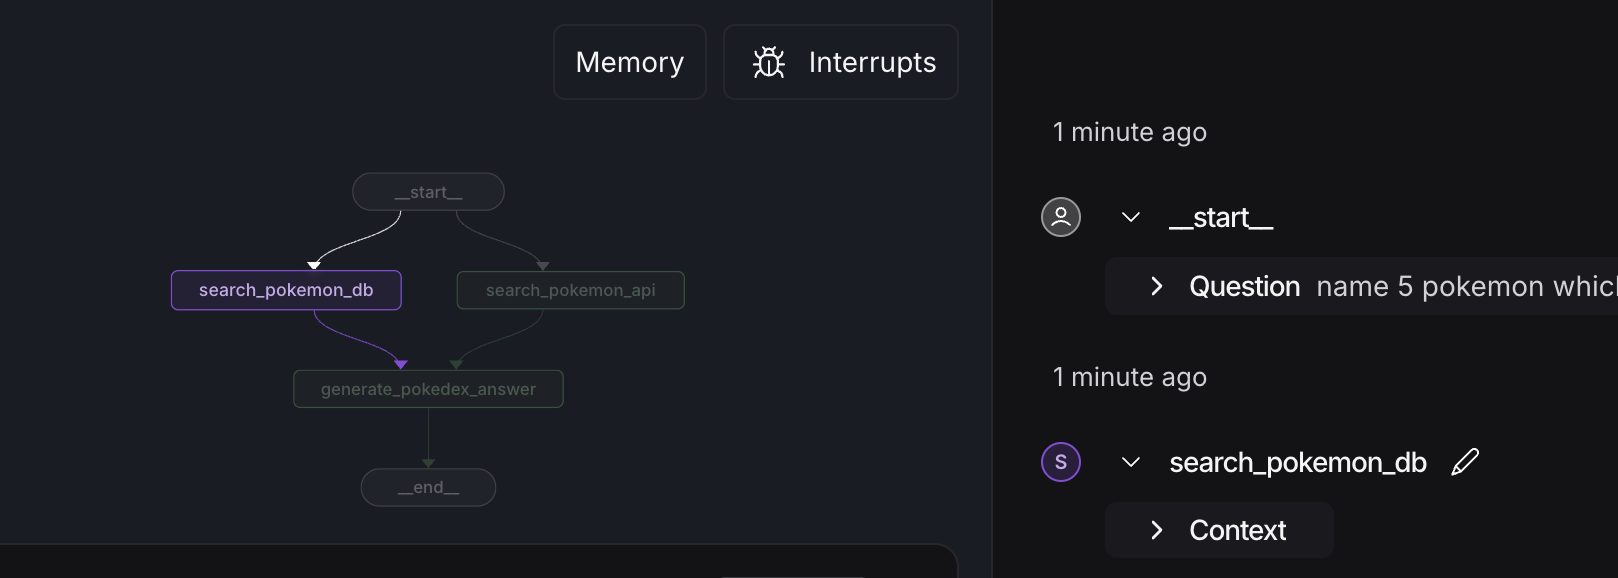

second search function

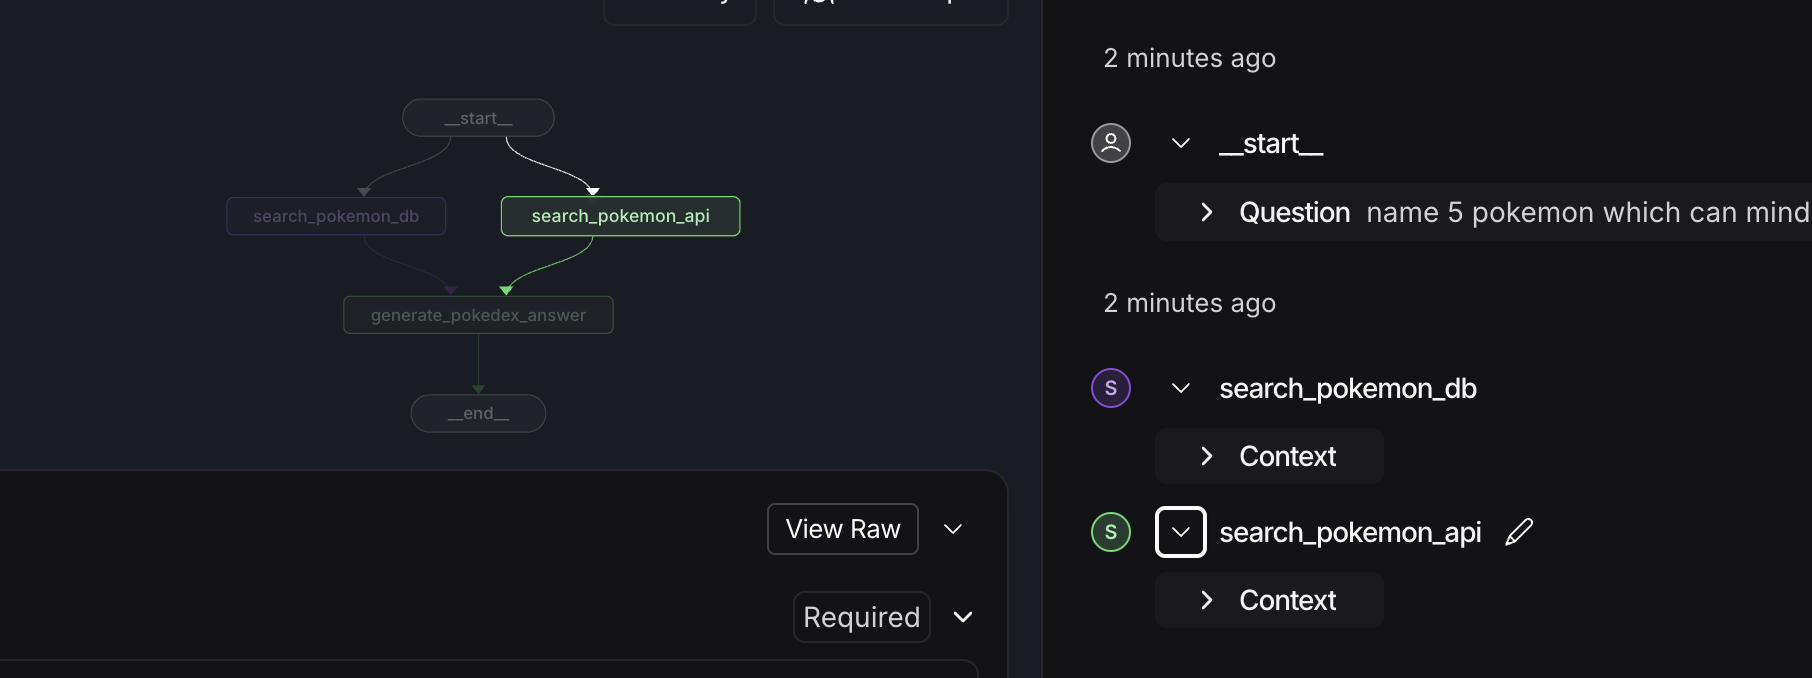

the third and last step for the llm call, which uses the output of 2nd step as input

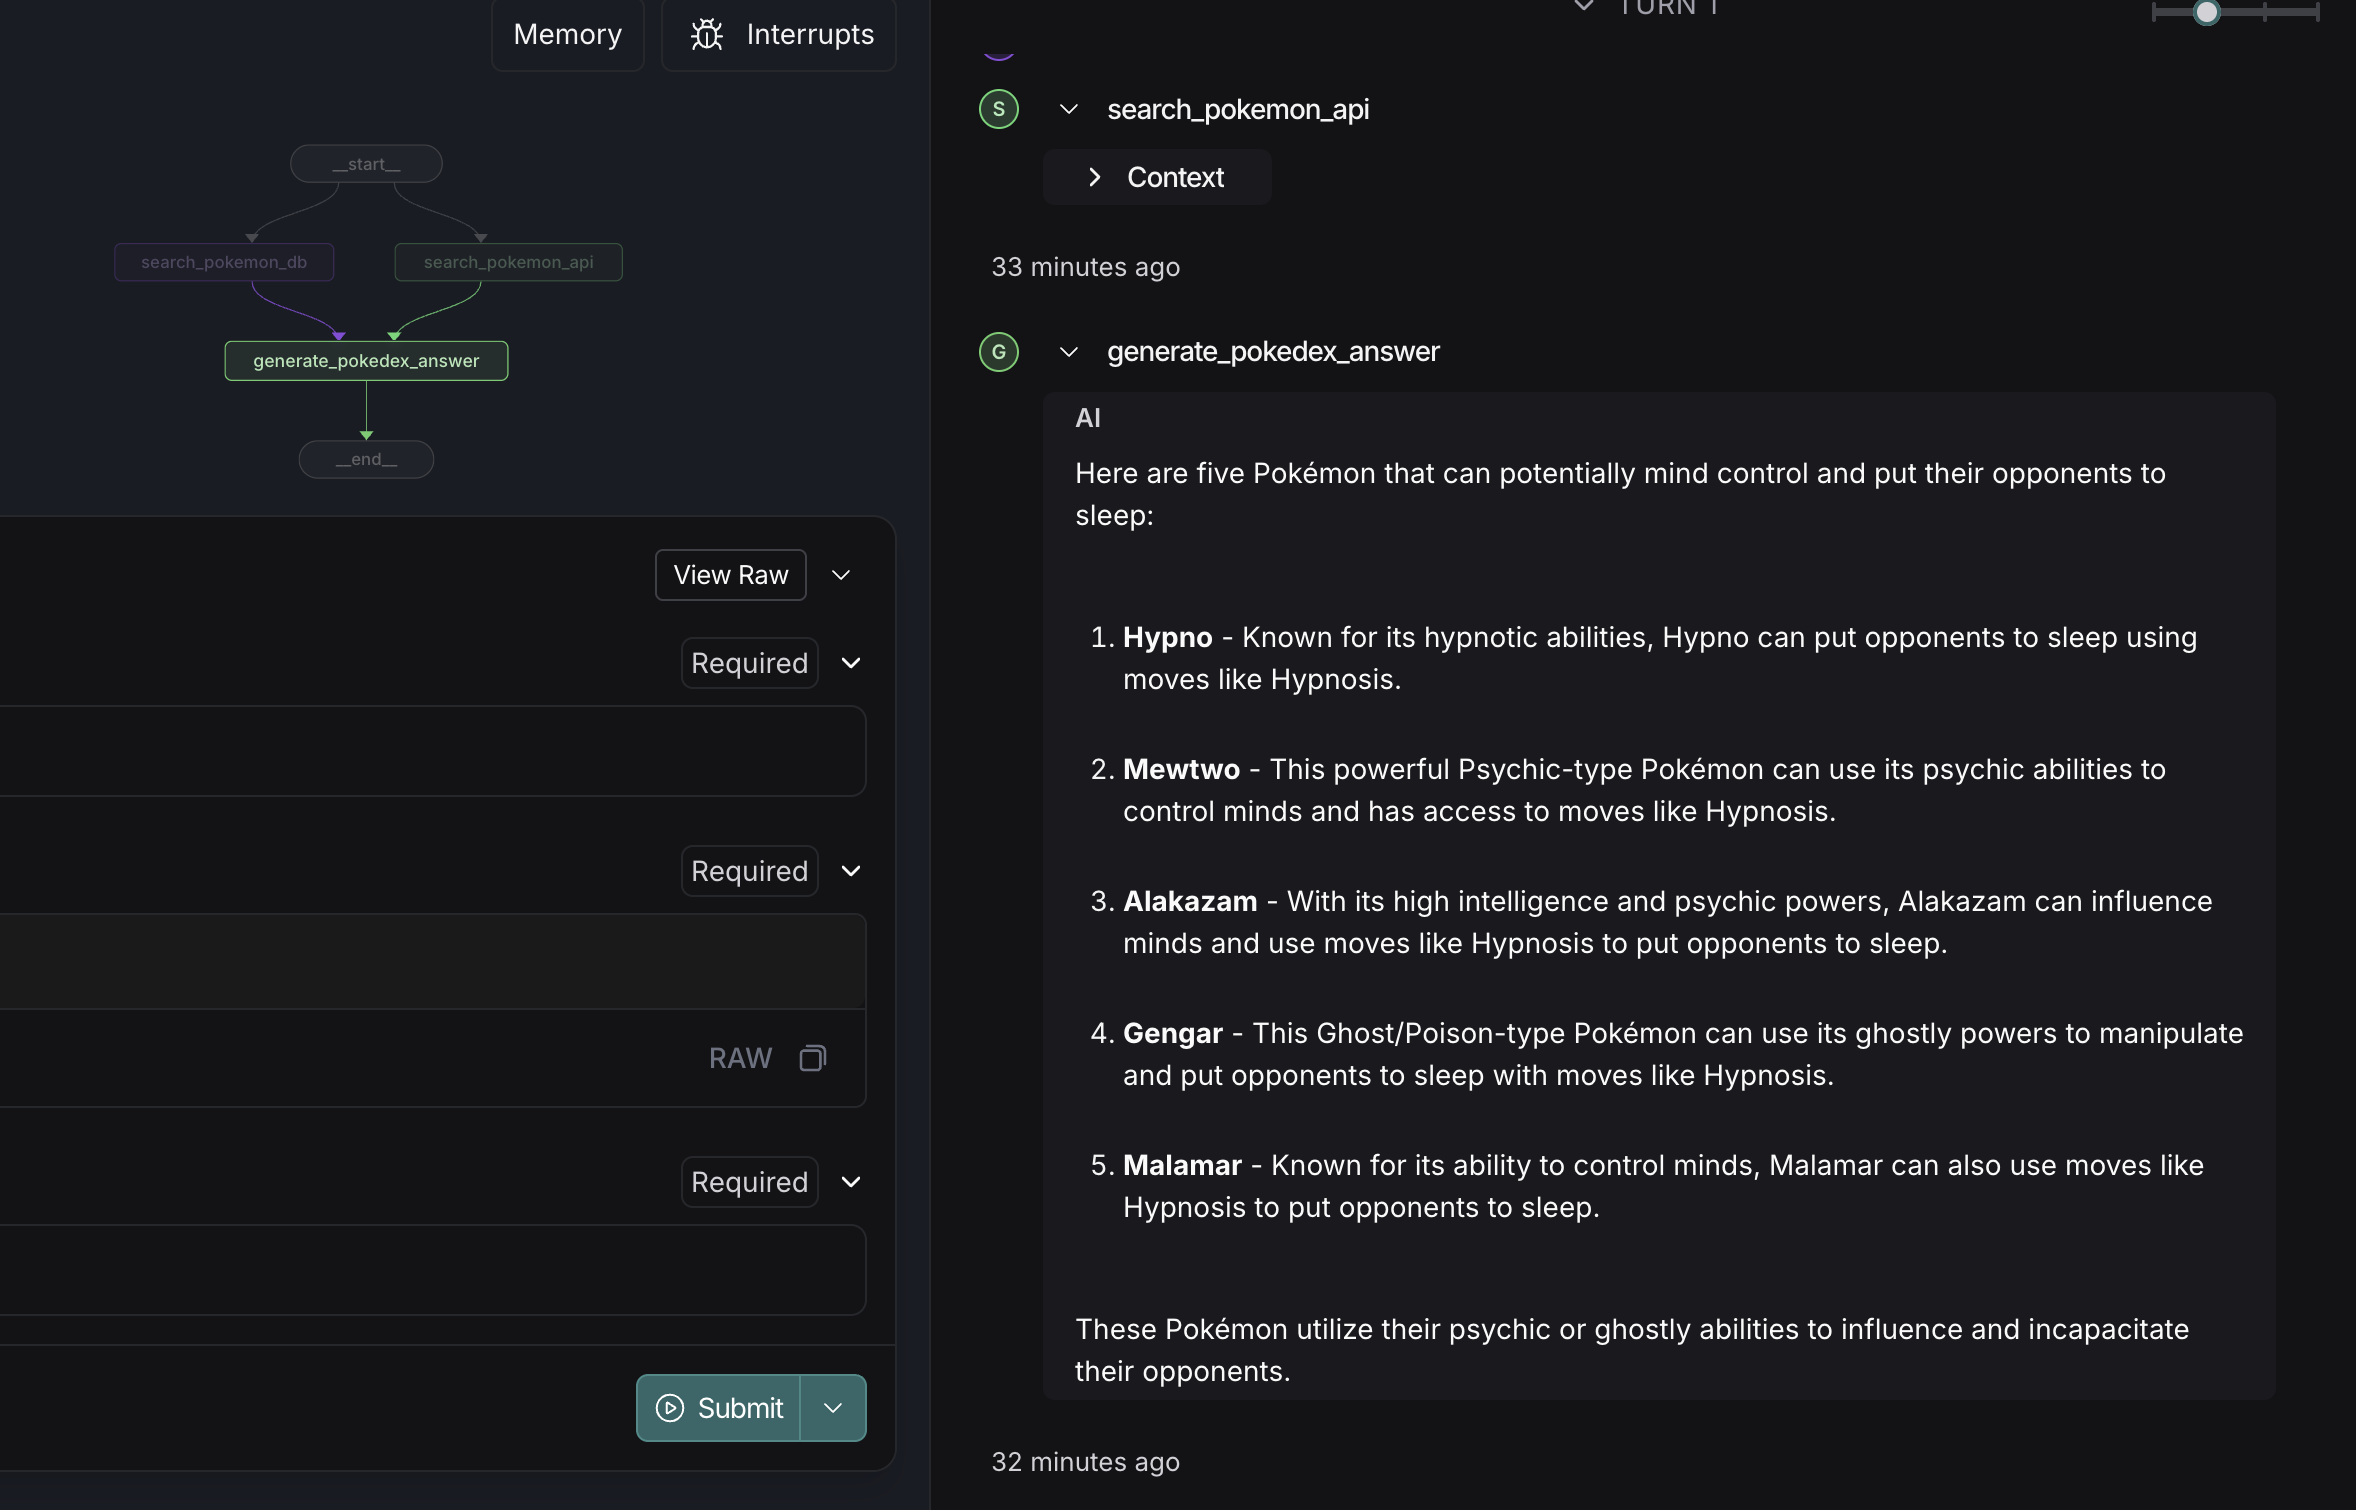